In [7]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
os.chdir('/Users/simon/Desktop/personal/immo_datacollection/house_scraping_project/')
import importlib
import src.preprocess_functions as pp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

importlib.reload(pp)

<module 'src.preprocess_functions' from '/Users/simon/Desktop/personal/immo_datacollection/house_scraping_project/src/preprocess_functions.py'>

In [8]:
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

# Augment data
Add features like price_per_sq_meter

In [11]:
df = pd.read_csv('outputs/property_data_raw.csv')
df = pp.preprocess(df)
df

Summary for number_of_bedrooms:
Coefficients: [0.00832075 0.69524019]
Intercept: 1.1634627690239432
Mean Squared Error: 0.925459825750242
R-squared: 0.36469537739441904

Summary for number_of_toilets:
Coefficients: [0.00430369 0.02059954 0.15877795]
Intercept: 0.4811184970058964
Mean Squared Error: 0.4438964241676942
R-squared: 0.39346346570937085

Summary for number_of_bathrooms:
Coefficients: [-6.15513792e-05 -2.83954625e-01  1.44654795e-01  4.57193885e-01]
Intercept: 0.31188867651857466
Mean Squared Error: 0.4647739221871714
R-squared: 0.2947565869830746

Summary for cadastral_income:
Coefficients: [   1.53984222 -117.66128441]
Intercept: 391.6871256949174
Mean Squared Error: 171308.6475409836
R-squared: 0.3581836794706825



,property_id,date_obtained,price,livable_area,heating_type,has_photovoltaic_panels,has_double_glazing,number_of_bathrooms,number_of_bedrooms,number_of_toilets,has_living_room,has_attic,has_basement,has_terrace,terrace_surface,has_garden,garden_surface,energy_label,primary_energy_consumption,postal_code,latitude,longitude,year_built,building_condition,property_size,flood_zone_type,cadastral_income,age,price_sq,property_type_HOUSE,neighbourhood
17334,11341004,2024-05-16,289.0,121.0,GAS,True,False,1.0,3.0,1.0,False,False,False,False,0.0,False,0.0,D,319.000000,9000,51.063490,3.704824,NaN,GOOD,60.0,Unknown,468.0,NaN,2.388430,True,Rabot - Blaisantvest
14019,11351745,2024-05-16,384.0,150.0,GAS,False,True,1.0,3.0,2.0,True,False,True,True,0.0,False,0.0,B,139.000000,9000,51.044219,3.757021,1935.0,AS_NEW,NaN,Unknown,983.0,89.0,2.560000,False,Oud Gentbrugge
103078,11363582,2024-05-16,1170.0,418.0,GAS,False,True,2.0,7.0,3.0,True,True,False,False,0.0,True,45.0,C,284.000000,9000,51.048579,3.733826,1875.0,GOOD,210.0,NON_FLOOD_ZONE,1921.0,149.0,2.799043,True,Binnenstad
38050,11235685,2024-05-16,459.0,112.0,Unknown,False,False,2.0,3.0,1.0,False,False,False,True,10.0,False,0.0,A,98.000000,9000,51.034638,3.734309,2012.0,Unknown,NaN,Unknown,1162.0,12.0,4.098214,False,Ledeberg
42572,11347349,2024-05-16,170.0,25.0,GAS,False,True,1.0,1.0,1.0,True,False,False,False,0.0,False,0.0,C,298.000000,9000,51.055810,3.711183,NaN,GOOD,NaN,NON_FLOOD_ZONE,285.0,NaN,6.800000,False,Elisabethbegijnhof - Prinsenhof - Papegaai - S...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142391,11395666,2024-10-06,210.0,99.0,GAS,False,False,1.0,2.0,1.0,True,False,True,False,0.0,False,0.0,D,358.000000,9000,51.069865,3.706994,NaN,Unknown,62.0,NON_FLOOD_ZONE,597.0,NaN,2.121212,True,Bloemekenswijk
142390,20023203,2024-10-06,2925.0,550.0,Unknown,False,False,3.0,4.0,3.0,True,True,False,True,0.0,False,0.0,F,726.553719,9031,51.035868,3.616661,1970.0,TO_BE_DONE_UP,4291.0,NON_FLOOD_ZONE,4778.0,54.0,5.318182,True,Drongen
142389,20175366,2024-10-06,549.0,199.0,GAS,True,True,1.0,4.0,2.0,True,False,False,False,0.0,False,0.0,A,47.000000,9940,51.122315,3.719063,2020.0,AS_NEW,362.0,NON_FLOOD_ZONE,1029.0,4.0,2.758794,True,Unknown
142386,9893467,2024-10-06,95.0,68.0,ELECTRIC,False,True,1.0,1.0,1.0,True,False,True,False,0.0,False,0.0,C,201.000000,9051,51.023585,3.694947,1995.0,Unknown,NaN,Unknown,538.0,29.0,1.397059,False,Sint-Denijs-Westrem - Afsnee


In [12]:
df.date_obtained.value_counts()

date_obtained
2024-10-06    1487
2024-09-30     669
2024-06-30     586
2024-07-20     429
2024-08-20     353
              ... 
2024-08-06       3
2024-05-18       3
2024-07-06       2
2024-07-12       2
2024-09-04       1
Name: count, Length: 82, dtype: int64

In [421]:
df[df.property_size.isna()].property_type_HOUSE.value_counts()

property_type_HOUSE
False    1185
Name: count, dtype: int64

In [422]:
df.prop

AttributeError: 'DataFrame' object has no attribute 'prop'

In [5]:
import requests
import pandas as pd

# Function to download compounds from ChEMBL
def download_chembl_compounds(num_compounds=5000):
    base_url = "https://www.ebi.ac.uk/chembl/api/data/molecule.json"
    compounds = []
    offset = 0
    limit = 1000  # Maximum number allowed per request by the API
    
    # Loop to fetch compounds until the desired number is reached
    while len(compounds) < num_compounds:
        response = requests.get(f"{base_url}?limit={limit}&offset={offset}")
        
        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break
        
        data = response.json()
        compounds.extend(data['molecules'])
        
        # Update offset to get the next set of compounds
        offset += limit

        # Stop when we reach the desired number
        if len(data['molecules']) == 0:
            break
    
    # Extract SMILES and ChEMBL ID from the compounds data
    smiles_list = []
    chembl_ids = []
    for compound in compounds:
        if 'molecule_structures' in compound and compound['molecule_structures'] is not None:
            smiles = compound['molecule_structures']['canonical_smiles']
            smiles_list.append(smiles)
            chembl_ids.append(compound['molecule_chembl_id'])

        # Stop if we've reached the requested number of compounds
        if len(smiles_list) >= num_compounds:
            break

    # Create a DataFrame with the downloaded data
    df = pd.DataFrame({'chembl_id': chembl_ids, 'smiles': smiles_list})
    return df

# Download approximately 5,000 compounds from ChEMBL
df_chembl = download_chembl_compounds(num_compounds=5000)

# Display the first few rows
print(df_chembl.head())

# Save the data to a CSV file
df_chembl.to_csv('chembl_5000_compounds.csv', index=False)
print(f"Saved {len(df_chembl)} compounds to 'chembl_5000_compounds.csv'")

      chembl_id                                            smiles
0    CHEMBL6329      Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl
1    CHEMBL6328   Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1
2  CHEMBL265667  Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1
3    CHEMBL6362      Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1
4  CHEMBL267864    Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1
Saved 4963 compounds to 'chembl_5000_compounds.csv'


In [6]:
df_chembl

,chembl_id,smiles
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1
...,...,...
4958,CHEMBL9651,CCN(C)c1c(N[C@@H](Cc2ccc(NC(=O)c3c(Cl)cncc3Cl)...
4959,CHEMBL266250,Oc1ccccc1N1CCNCC1
4960,CHEMBL9434,c1ccc(N2CCNCC2)cc1
4961,CHEMBL267153,O=[N+]([O-])c1cccc(N2CCNCC2)c1


[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerator
[20:03:57] DEPRECATION WARNING: please use MorganGenerat

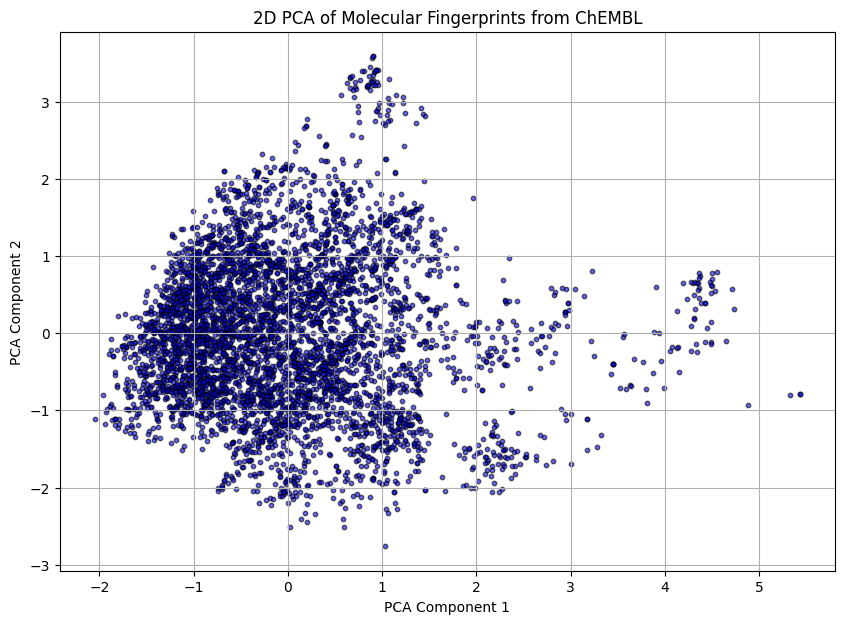

In [8]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to convert SMILES to molecular fingerprints
def smiles_to_fingerprint(smiles_list, n_bits=2048):
    fingerprints = []
    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
                fingerprints.append(np.array(fp))
            else:
                fingerprints.append(np.zeros(n_bits))  # Handle failed molecule parsing
        except:
            fingerprints.append(np.zeros(n_bits))  # Handle exceptions gracefully
    return np.array(fingerprints)

# Load the ChEMBL compounds data
df_chembl = pd.read_csv('chembl_5000_compounds.csv')

# Convert SMILES to molecular fingerprints
fingerprints = smiles_to_fingerprint(df_chembl['smiles'].tolist())

# Perform PCA on the fingerprints to reduce to 2 dimensions
pca = PCA(n_components=2)
fingerprints_pca = pca.fit_transform(fingerprints)

# Add PCA results to the dataframe for easy plotting
df_chembl['PCA1'] = fingerprints_pca[:, 0]
df_chembl['PCA2'] = fingerprints_pca[:, 1]

# Plot the 2D PCA projection
plt.figure(figsize=(10, 7))
plt.scatter(df_chembl['PCA1'], df_chembl['PCA2'], c='blue', edgecolor='k', s=10, alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of Molecular Fingerprints from ChEMBL')
plt.grid(True)
plt.show()

/Users/simon/Desktop/personal/immo_datacollection/house_scraping_project/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


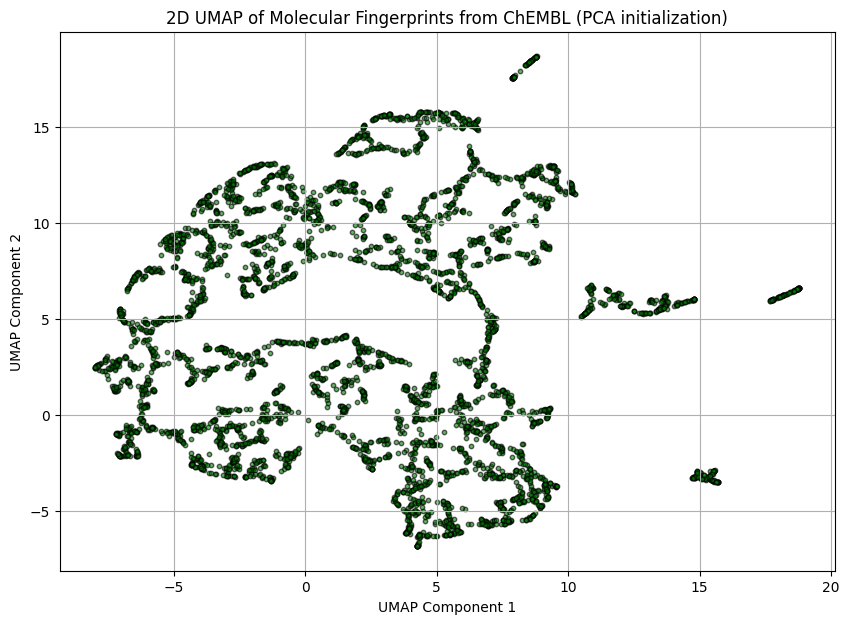

In [10]:
import umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, init=fingerprints_pca, random_state=42)
fingerprints_umap = umap_model.fit_transform(fingerprints_pca)

# Add UMAP results to the dataframe
df_chembl['UMAP1'] = fingerprints_umap[:, 0]
df_chembl['UMAP2'] = fingerprints_umap[:, 1]

# Plot the 2D UMAP projection
plt.figure(figsize=(10, 7))
plt.scatter(df_chembl['UMAP1'], df_chembl['UMAP2'], c='green', edgecolor='k', s=10, alpha=0.6)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('2D UMAP of Molecular Fingerprints from ChEMBL (PCA initialization)')
plt.grid(True)
plt.show()

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)
df_chembl['cluster'] = dbscan.fit_predict(fingerprints_umap)
df_chembl

,chembl_id,smiles,PCA1,PCA2,UMAP1,UMAP2,cluster
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,-0.962387,-0.740385,-3.272911,-1.380622,0
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,-0.816939,-0.242696,-2.861177,2.576889,0
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,-1.043246,-0.310214,-4.304989,2.230475,0
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,-0.830906,-0.169520,-2.844487,3.119601,0
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,-0.984394,-0.474716,-3.306082,0.356817,0
...,...,...,...,...,...,...,...
4958,CHEMBL9651,CCN(C)c1c(N[C@@H](Cc2ccc(NC(=O)c3c(Cl)cncc3Cl)...,1.144350,-1.399954,8.616730,-4.376393,3
4959,CHEMBL266250,Oc1ccccc1N1CCNCC1,-0.858789,0.300763,-3.335628,7.887537,0
4960,CHEMBL9434,c1ccc(N2CCNCC2)cc1,-0.924504,0.124047,-3.997787,6.245780,0
4961,CHEMBL267153,O=[N+]([O-])c1cccc(N2CCNCC2)c1,-1.043133,0.275013,-4.717738,7.437644,0


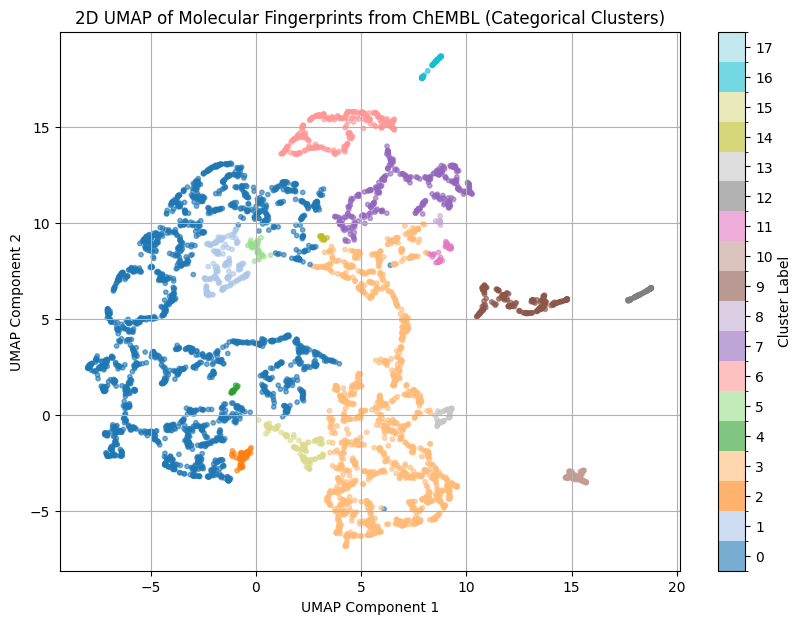

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get unique cluster labels
unique_clusters = df_chembl['cluster'].unique()

# Define a qualitative colormap to use for categorical data
cmap = plt.get_cmap('tab20', len(unique_clusters))  # 'tab20' is a good categorical colormap

# Create a color map with a different color for each cluster
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_clusters) + 1) - 0.5, ncolors=len(unique_clusters))

# Create the scatter plot with cluster categories as discrete colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_chembl['UMAP1'], df_chembl['UMAP2'], c=df_chembl['cluster'], cmap=cmap, norm=norm, s=10, alpha=0.6)

# Create a color bar using cluster labels
cbar = plt.colorbar(scatter, ticks=range(len(unique_clusters)))
cbar.set_label('Cluster Label')

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('2D UMAP of Molecular Fingerprints from ChEMBL (Categorical Clusters)')
plt.grid(True)
plt.show()

In [19]:
def find_common_substructures(smiles_list):
    mols = [Chem.MolFromSmiles(sm) for sm in smiles_list if Chem.MolFromSmiles(sm)]
    common_fragments = {}
    for mol in mols:
        fragments = [Chem.MolToSmiles(frag) for frag in Chem.GetMolFrags(mol, asMols=True)]
        for frag in fragments:
            if frag in common_fragments:
                common_fragments[frag] += 1
            else:
                common_fragments[frag] = 1
    return sorted(common_fragments.items(), key=lambda item: item[1], reverse=True)


# Analyze common substructures within clusters
for cluster_id in df_chembl['cluster'].unique():
    if cluster_id == -1:  # Ignore noise points
        continue
    cluster_smiles = df_chembl[df_chembl['cluster'] == cluster_id]['smiles'].tolist()
    print(f"Cluster {cluster_id}:")
    common_substructures = find_common_substructures(cluster_smiles)
    print("Most common substructures:")
    for substructure, count in common_substructures[:5]:  # Show top 5 substructures
        print(f"{substructure}: {count} occurrences")
    print()

Cluster 0:
Most common substructures:
[Br-]: 46 occurrences
Cl: 23 occurrences
CS(=O)(=O)[O-]: 20 occurrences
[Cl-]: 9 occurrences
CS(=O)(=O)O: 5 occurrences

Cluster 1:
Most common substructures:
[Br-]: 23 occurrences
Cl: 5 occurrences
[Cl-]: 2 occurrences
O=C1O/C(=C/I)CCC1c1cccc2ccccc12: 1 occurrences
O=C1O/C(=C\I)CCC1c1cccc2ccccc12: 1 occurrences

Cluster 2:
Most common substructures:
c1ccc(C[n+]2ccc(NCCCCCCCCCCNc3cc[n+](Cc4ccccc4)c4ccccc34)c3ccccc32)cc1: 1 occurrences
Cc1ccc(Sc2cncc3sc(C(=O)NN)cc23)cc1: 1 occurrences
CCCC/C(=C\Cn1oc(=O)[nH]c1=O)c1cccc(OCc2nc(-c3ccc(C(F)(F)F)cc3)oc2-c2ccccc2)c1: 1 occurrences
CCN(CC)c1cccnc1N1CCN(C(=O)c2cc3ccccc3[nH]2)CC1: 1 occurrences
CCNc1cccnc1N1CCN(C(=O)c2nc3ccccc3[nH]2)CC1: 1 occurrences

Cluster 3:
Most common substructures:
[Na+]: 47 occurrences
Cl: 11 occurrences
Br: 11 occurrences
O=C(O)C(F)(F)F: 6 occurrences
CS(=O)(=O)O: 3 occurrences

Cluster 4:
Most common substructures:
COc1cc2nc(N3CCN(C(=O)/C=C/c4ccccc4)CC3)nc(N)c2cc1OC: 1 occurrence